# Simple autoencoder

## 1.Import modules and set paths
Modify here to load files from different places.

All used libraries are here.

In [55]:
# Mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

# Data managment 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler

import torch as t
from torch import nn, optim
from torch.utils import data as data_lib
import torch.nn.functional as F

# Utilities
import os
from sklearn import preprocessing

proj_folder = '/content/gdrive/My Drive/ColabNotebooks/PAN_autoencoder_first_tries/'
data_folder = proj_folder + 'data/'
solutions_folder = proj_folder + 'data/solutions/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2.Load and select data
In this model **alias_global_Outlier** will be used as label.

In [0]:
%%capture
#Get RAW Data
if not os.path.isfile('trending_merged_LHC18f_withGraphs.csv'):
    if not os.path.isfile('CERNdata.zip'):
        !wget 'https://cernbox.cern.ch/index.php/s/JnxbQZ0nzITGC4i/download' -O CERNdata.zip
    !7z x CERNdata.zip

In [0]:
#Proton-Proton
raw_f = pd.read_csv('trending_merged_LHC18f_withGraphs.csv')
raw_f['period'] = 'LHC18f'
raw_o = pd.read_csv('trending_merged_LHC18o_withGraphs.csv')
raw_o['period'] = 'LHC18o'
raw_p = pd.read_csv('trending_merged_LHC18p_withGraphs.csv')
raw_p['period'] = 'LHC18p'

In [58]:
raw = pd.concat([raw_f, raw_o, raw_p])
raw.head()

,Unnamed: 0,run,chunkID,time,year,period.fString,pass.fString,dataType.fString,startTimeGRP,stopTimeGRP,duration,bz,runType.fString,meanTPCnclF,rmsTPCnclF,meanTPCChi2,rmsTPCChi2,slopeATPCnclF,slopeCTPCnclF,slopeATPCnclFErr,slopeCTPCnclFErr,meanTPCncl,rmsTPCncl,slopeATPCncl,slopeCTPCncl,slopeATPCnclErr,slopeCTPCnclErr,hasRawQA,rawClusterCounter,rawSignalCounter,offsetdZA,slopedZA,offsetdZC,slopedZC,offsetdZAErr,slopedZAErr,offsetdZCErr,slopedZCErr,offsetdZAchi2,slopedZAchi2,...,grdcaz_neg_CSidePhi_Y_106,grdcaz_neg_CSidePhi_Y_107,grdcaz_neg_CSidePhi_Y_108,grdcaz_neg_CSidePhi_Y_109,grdcaz_neg_CSidePhi_Y_110,grdcaz_neg_CSidePhi_Y_111,grdcaz_neg_CSidePhi_Y_112,grdcaz_neg_CSidePhi_Y_113,grdcaz_neg_CSidePhi_Y_114,grdcaz_neg_CSidePhi_Y_115,grdcaz_neg_CSidePhi_Y_116,grdcaz_neg_CSidePhi_Y_117,grdcaz_neg_CSidePhi_Y_118,grdcaz_neg_CSidePhi_Y_119,grdcaz_neg_CSidePhi_Y_120,grdcaz_neg_CSidePhi_Y_121,grdcaz_neg_CSidePhi_Y_122,grdcaz_neg_CSidePhi_Y_123,grdcaz_neg_CSidePhi_Y_124,grdcaz_neg_CSidePhi_Y_125,grdcaz_neg_CSidePhi_Y_126,grdcaz_neg_CSidePhi_Y_127,grdcaz_neg_CSidePhi_Y_128,grdcaz_neg_CSidePhi_Y_129,grdcaz_neg_CSidePhi_Y_130,grdcaz_neg_CSidePhi_Y_131,grdcaz_neg_CSidePhi_Y_132,grdcaz_neg_CSidePhi_Y_133,grdcaz_neg_CSidePhi_Y_134,grdcaz_neg_CSidePhi_Y_135,grdcaz_neg_CSidePhi_Y_136,grdcaz_neg_CSidePhi_Y_137,grdcaz_neg_CSidePhi_Y_138,grdcaz_neg_CSidePhi_Y_139,grdcaz_neg_CSidePhi_Y_140,grdcaz_neg_CSidePhi_Y_141,grdcaz_neg_CSidePhi_Y_142,grdcaz_neg_CSidePhi_Y_143,interactionRate,period
0,0,287000,1,1527204124,2018,LHC18f,pass1,NaN,1527204124,1527231797,27673,-0.499998,PHYSICS,0.913711,0.091254,1.767776,0.446999,-0.003785,0.000947,0.000674,0.000947,133.596942,22.675932,-0.061015,-0.029429,0.172744,-0.029429,1,367302864,547136439,0.008433,0.061533,-0.095885,0.060379,0.002402,0.005589,0.002441,0.005575,54.538913,54.538913,...,-0.052315,-0.058496,-0.057705,-0.007200,-0.066442,-0.079369,-0.117361,-0.061361,-0.099326,-0.078831,-0.097516,-0.107208,-0.109287,-0.102642,-0.066415,-0.069376,-0.061681,-0.096441,-0.055511,-0.059102,-0.068315,-0.102027,-0.086352,-0.070171,-0.066603,-0.059391,-0.111429,-0.073658,-0.090766,-0.029640,-0.084562,-0.079724,-0.069284,-0.045167,-0.065301,-0.050480,-0.050551,-0.069094,195584.670984,LHC18f
1,1,287000,2,1527204124,2018,LHC18f,pass1,NaN,1527204124,1527231797,27673,-0.499998,PHYSICS,0.913795,0.091471,1.765181,0.446966,-0.004339,0.000274,0.000660,0.000274,133.604316,22.668970,-0.227194,-0.046269,0.170329,-0.046269,1,367302864,547136439,0.007302,0.050437,0.041850,0.239221,0.002347,0.005482,0.002514,0.005686,80.242746,80.242746,...,-0.013811,-0.043341,-0.036767,-0.008760,-0.059732,-0.010744,-0.024306,-0.056385,-0.063628,-0.059174,-0.067915,-0.013919,-0.018712,-0.042576,-0.029183,-0.065051,-0.074004,-0.062315,-0.098015,-0.032065,-0.039085,-0.037202,-0.020365,-0.052420,-0.092947,-0.017293,-0.044535,-0.009809,-0.026729,-0.048561,-0.006055,-0.034508,-0.051278,-0.038319,0.017724,0.012698,-0.032471,-0.020261,195584.670984,LHC18f
2,2,287000,3,1527204124,2018,LHC18f,pass1,NaN,1527204124,1527231797,27673,-0.499998,PHYSICS,0.913980,0.091291,1.766238,0.447530,-0.003400,0.000098,0.000655,0.000098,133.619454,22.658997,-0.226418,-0.220931,0.169301,-0.220931,1,367302864,547136439,0.018170,0.035006,0.122846,0.356713,0.002312,0.005374,0.002513,0.005630,84.160363,84.160363,...,-0.005258,0.001520,-0.004679,0.067023,0.020974,-0.022892,-0.021963,-0.054784,-0.065607,-0.046039,-0.033981,-0.057274,-0.023231,-0.018649,0.002054,-0.031758,-0.085111,-0.042000,0.024556,-0.053818,-0.004125,-0.005745,0.006034,-0.042845,-0.028715,0.006710,-0.015597,-0.024007,-0.001764,-0.029742,-0.010322,-0.021278,0.031273,0.034793,0.030032,0.017758,-0.000799,0.018394,195584.670984,LHC18f
3,3,287000,4,1527204124,2018,LHC18f,pass1,NaN,1527204124,1527231797,27673,-0.499998,PHYSICS,0.913710,0.091409,1.769212,0.448276,-0.003525,-0.000843,0.000665,-0.000843,133.561797,22.654738,-0.160837,-0.230723,0.169628,-0.230723,1,367302864,547136439,0.010970,0.044343,0.186074,0.444474,0.0

In [59]:
#Define meta data, graphs, aliases
meta_cols = ['period', 'run', 'chunkID', 'time', 'year', 'period.fString', 'pass.fString', 
'runType.fString', 'startTimeGRP', 'stopTimeGRP', 'duration', 'chunkStart', 
'chunkStop', 'chunkMean', 'chunkMedian', 'chunkRMS', 
'chunkDuration'] + ['Unnamed: 0', 'dataType.fString' ] # After + my opinion

graph_cols = [col for col in raw if col.startswith('gr')] # +6k

alias_cols = [col for col in raw if col.startswith('alias_')] #265

#Point to label columns
war_col = 'alias_global_Warning'
out_col = 'alias_global_Outlier'

period = raw['period']
run = raw['run']
chunkID = raw['chunkID']

# Filter out data not used for classification.
filtered = raw.drop(meta_cols + graph_cols + alias_cols, axis=1)
no_samples, no_features = filtered.shape

#Check shape
print(no_samples, no_features)
filtered.head()

3429 239


,bz,meanTPCnclF,rmsTPCnclF,meanTPCChi2,rmsTPCChi2,slopeATPCnclF,slopeCTPCnclF,slopeATPCnclFErr,slopeCTPCnclFErr,meanTPCncl,rmsTPCncl,slopeATPCncl,slopeCTPCncl,slopeATPCnclErr,slopeCTPCnclErr,hasRawQA,rawClusterCounter,rawSignalCounter,offsetdZA,slopedZA,offsetdZC,slopedZC,offsetdZAErr,slopedZAErr,offsetdZCErr,slopedZCErr,offsetdZAchi2,slopedZAchi2,offsetdZCchi2,slopedZCchi2,offsetdZAPos,slopedZAPos,offsetdZCPos,slopedZCPos,offsetdZAErrPos,slopedZAErrPos,offsetdZCErrPos,slopedZCErrPos,offsetdZAchi2Pos,slopedZAchi2Pos,...,oroc_C_side,MIPattachSlopeC,MIPattachSlopeA,resolutionMIP,meanMIP,meanMIPele,resolutionMIPele,electroMIPSeparation,tpcItsMatchA,tpcItsMatchHighPtA,tpcItsMatchC,tpcItsMatchHighPtC,phiPull,phiPullHighPt,ptPull,ptPullHighPt,yPull,yPullHighPt,zPull,zPullHighPt,lambdaPull,lambdaPullHighPt,tpcConstrainPhiA,tpcConstrainPhiC,meanPTRelativeA,medianPTRelativeA,rmsPTRelativeA,meanPTRelativeC,medianPTRelativeC,rmsPTRelativeC,meanHVandPTGainCorrIROC,medianHVandPTGainCorrIROC,rmsHVandPTGainCorrIROC,meanHVandPTGainCorrOROC,medianHVandPTGainCorrOROC,rmsHVandPTGainCorrOROC,meanVDriftCorr,medianVDriftCorr,rmsVDriftCorr,interactionRate
0,-0.499998,0.913711,0.091254,1.767776,0.446999,-0.003785,0.000947,0.000674,0.000947,133.596942,22.675932,-0.061015,-0.029429,0.172744,-0.029429,1,367302864,547136439,0.008433,0.061533,-0.095885,0.060379,0.002402,0.005589,0.002441,0.005575,54.538913,54.538913,1447.258711,1447.258711,0.011558,0.084150,-0.093813,0.087700,0.003431,0.008177,0.003531,0.008089,9.050547,9.050547,...,18,0.030036,-0.173266,0.064220,49.792557,80.735855,0.055183,30.943298,0.699384,0.710692,0.694623,0.703207,-0.000119,-0.000389,0.527906,0.738438,-0.092014,-0.210392,-0.088328,-0.156770,0.119385,0.068962,0.017818,-0.049315,0.003437,0.003433,0.000011,0.003560,0.003556,0.000011,1.128413,1.128399,0.000043,1.128413,1.128399,0.000043,-0.027221,-0.027222,3.005739e-06,195584.670984
1,-0.499998,0.913795,0.091471,1.765181,0.446966,-0.004339,0.000274,0.000660,0.000274,133.604316,22.668970,-0.227194,-0.046269,0.170329,-0.046269,1,367302864,547136439,0.007302,0.050437,0.041850,0.239221,0.002347,0.005482,0.002514,0.005686,80.242746,80.242746,2298.826852,2298.826852,0.006364,0.079816,0.040957,0.262827,0.003490,0.008128,0.003665,0.008344,35.407343,35.407343,...,18,-0.046077,-0.174695,0.064034,49.808353,80.820270,0.055974,31.011913,0.698263,0.696498,0.692948,0.703005,-0.000016,0.001378,0.533350,0.784235,-0.053545,-0.088791,-0.077231,-0.174282,0.118407,0.125998,0.008589,-0.031984,0.003476,0.003474,0.000017,0.003597,0.003596,0.000017,1.128563,1.128559,0.000066,1.128563,1.128559,0.000066,-0.027226,-0.027226,8.138511e-07,195584.670984
2,-0.499998,0.913980,0.091291,1.766238,0.447530,-0.003400,0.000098,0.000655,0.000098,133.619454,22.658997,-0.226418,-0.220931,0.169301,-0.220931,1,367302864,547136439,0.018170,0.035006,0.122846,0.356713,0.002312,0.005374,0.002513,0.005630,84.160363,84.160363,2689.649719,2689.649719,0.018739,0.060694,0.122070,0.383957,0.003383,0.007934,0.003700,0.008220,64.929950,64.929950,...,18,-0.040411,-0.132918,0.063939,49.698433,80.666520,0.055939,30.968086,0.700643,0.707197,0.693301,0.706140,-0.000104,0.000041,0.534116,0.760895,-0.058528,-0.119211,-0.078093,-0.172614,0.118760,0.088854,0.012813,-0.016630,0.003457,0.003462,0.000018,0.003578,0.003583,0.000018,1.128491,1.128508,0.000068,1.128491,1.128508,0.000068,-0.027230,-0.027230,2.510162e-06,195584.670984
3,-0.499998,0.913710,0.091409,1.769212,0.448276,-0.003525,-0.000843,0.000665,-0.000843,133.561797,22.654738,-0.160837,-0.230723,0.169628,-0.230723,1,367302864,547136439,0.010970,0.044343,0.186074,0.444474,0.002419,0.005634,0.002601,0.005870,60.973159,60.973159,2930.115067,2930.115067,0.011269,0.076198,0.189182,0.477827,0.003562,0.008437,0.003797,0.008594,38.295893,38.295893,...,18,-0.011914,-0.215666,0.064052,49.721306,80.747475,0.055767,31.026169,0.693546,0.691877,0.686828,0.708658,-0.000176,0.000900,0.535176,0.826308,-0.044240,-0.047569,-0.071471,-0.156174,0.111323,0.044026,0

## 3.Create and shuffle indices
Also check amount of flagged and not flagged

In [60]:
# Always there is warning when there is error!

# [0] becasue silly 'where' returns touple
crit = raw[war_col].astype(bool)
f_indices = np.where(crit)[0] # Flagged indices
no_f_indices = np.where(~crit)[0] # Not flagged indices

# Number of flagged elements
print(len(f_indices))
# Number of not flagged elements
print(len(no_f_indices))

#Shuffle intances to ensure that with each run different samples are drawn
random_seed= 42 # Controlled randomnes
np.random.seed(random_seed)
np.random.shuffle(f_indices)
np.random.shuffle(no_f_indices)

167
3262


## 4.Preprocess and create generators.
Generators will be used for training, validation and test.

Some specific features of PyTorch are used.

In [61]:
#Parameters
params = {'batch_size': 16,
          'num_workers': 8}
scaler = MaxAbsScaler()
# scaler = MinMaxScaler()

# 10% of all correct instances will be used as validation
valid_split = int(np.floor(.1 * len(no_f_indices))) 
# 70 correct and 70 flagged samples will be used as test
test_split = 70

#Create dataset
X = t.FloatTensor(scaler.fit_transform(filtered)) #features
Y = t.IntTensor(raw[war_col].to_numpy()) #labels
dataset = data_lib.TensorDataset(X,Y)

#Set training indices of correct cases
test_indices_c, valid_indices, train_indices = np.split(no_f_indices, [test_split, test_split+valid_split])
# Add flagged indices to test indices 
test_indices = np.concatenate((test_indices_c, f_indices[:test_split]))

# Create samplers
train_sampler = data_lib.SubsetRandomSampler(train_indices)
valid_sampler = data_lib.SubsetRandomSampler(valid_indices)
test_sampler = data_lib.SubsetRandomSampler(test_indices)

#Create generators
train_gen = data_lib.DataLoader(dataset, **params,sampler=train_sampler)
valid_gen = data_lib.DataLoader(dataset, **params, sampler=valid_sampler)
test_gen = data_lib.DataLoader(dataset, **params, sampler=test_sampler)

#Check if all fine
next(iter(test_gen))

[tensor([[ 1.0000,  0.9844,  0.8326,  ..., -0.2704,  0.2757,  0.3150],
         [ 1.0000,  0.9920,  0.8611,  ..., -0.5093,  0.3584,  0.0765],
         [-1.0000,  0.9856,  0.8122,  ..., -0.7395,  0.0793,  0.2339],
         ...,
         [ 1.0000,  0.9836,  0.8232,  ..., -0.4032,  0.0142,  0.3110],
         [-1.0000,  0.9561,  0.8409,  ..., -0.7714,  0.0084,  1.0000],
         [-1.0000,  0.9859,  0.8085,  ..., -0.7648,  0.1088,  0.2358]]),
 tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0], dtype=torch.int32)]

## 5.Defining architecture of Neural Network
Simple autoencoder with linear fully conected layers, dropout, relu act. i final tanh.

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(no_features, 150)
        self.fc2 = nn.Linear(150, 50)
        
        self.fc3 = nn.Linear(50, 20) # 100 latent variables
        self.fc4 = nn.Linear(20, 50)
        
        self.fc5 = nn.Linear(50, 150)
        self.fc6 = nn.Linear(150, no_features)  
        
        self.dropout = nn.Dropout(p=0.25)
        
    def forward(self, x):
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
                               
        x = t.tanh(self.fc6(x)) #last act funcion tanh
        return x

# Put net to model object
model = Autoencoder()
# Mean Square Error criterion
criterion = nn.MSELoss()
# Optimizer - Adam
optimizer = optim.Adam(model.parameters(), lr=0.003)

##6.Quick-Test Model Validity
Is it possible to pass data throught the model witout error?

In [63]:
# Load some variable for test (we dont care about labels)
features, labels = next(iter(test_gen))

#Check if size is correct, should be batch_size x no_features
print(features.shape)

# Show values after passing throught untrained network 
model.forward(features)[:5]

torch.Size([16, 239])


tensor([[ 0.0043,  0.0360, -0.0078,  ..., -0.0111, -0.1239,  0.0946],
        [ 0.0134,  0.0983,  0.0257,  ..., -0.0280, -0.0687,  0.0772],
        [ 0.0381,  0.0300,  0.0278,  ..., -0.0355, -0.0599,  0.0625],
        [ 0.0632,  0.0192,  0.0121,  ..., -0.0242, -0.0864,  0.0600],
        [ 0.0196,  0.0507,  0.0085,  ..., -0.0167, -0.0852,  0.1113]],
       grad_fn=<SliceBackward>)

## 7.Prepare for training

Check if training on GPU is possible and if yes move model.

In [64]:
# check if CUDA is available
gpu = t.cuda.is_available()

if not gpu:
    print('CUDA is not available.  Training on CPU ...')
    model.cpu()
else:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

CUDA is available!  Training on GPU ...


## 8.Train the network
Network is being trained only on **not flagged** data!

In [65]:
# number of epochs
n_epochs = 50

valid_loss_min = np.Inf # to track change in validation loss

# Iterate on epochs 
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Set model to train mode (to include dropout)
    model.train()
    
    # iterate on data batches, discard labels
    for features, _ in train_gen:
        # move tensors to GPU if CUDA is available
        if gpu:
            features = features.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs throught the model
        output = model.forward(features)
        # calculate the batch loss by compering to initial features
        loss = criterion(output, features)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update average validation loss, mulitply by batchsize for bigger nums
        train_loss += loss.item() *features.size(0)
          
    # Validate the model 
    
    # Set model to evaluation mode tu use its full power
    model.eval()
    
    for features, _ in valid_gen:
        # move tensors to GPU if CUDA is available
        if gpu:
            features = features.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(features)
        # calculate the batch loss by compering to initial features
        loss = criterion(output, features)
        # update average validation loss, mulitply by batchsize for bigger nums
        valid_loss += loss.item() *features.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_gen.sampler)
    valid_loss = valid_loss/len(valid_gen.sampler)
    
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        t.save(model.state_dict(), proj_folder + 'simple_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.0192 	Validation Loss: 0.005989
Validation loss decreased (inf --> 0.0060).  Saving model ...
Epoch: 2 	Training Loss: 0.0063 	Validation Loss: 0.004889
Validation loss decreased (0.0060 --> 0.0049).  Saving model ...
Epoch: 3 	Training Loss: 0.0056 	Validation Loss: 0.004873
Validation loss decreased (0.0049 --> 0.0049).  Saving model ...
Epoch: 4 	Training Loss: 0.0053 	Validation Loss: 0.004622
Validation loss decreased (0.0049 --> 0.0046).  Saving model ...
Epoch: 5 	Training Loss: 0.0052 	Validation Loss: 0.004668
Epoch: 6 	Training Loss: 0.0051 	Validation Loss: 0.004574
Validation loss decreased (0.0046 --> 0.0046).  Saving model ...
Epoch: 7 	Training Loss: 0.0052 	Validation Loss: 0.004749
Epoch: 8 	Training Loss: 0.0052 	Validation Loss: 0.004992
Epoch: 9 	Training Loss: 0.0050 	Validation Loss: 0.004594
Epoch: 10 	Training Loss: 0.0049 	Validation Loss: 0.004611
Epoch: 11 	Training Loss: 0.0051 	Validation Loss: 0.005027
Epoch: 12 	Training Loss: 0

## 9.Test and score counting
Load model which had smallest validation loss in training. 

**Count score**

Score is single value that allows for model evaluation. In this case it is counted as follows: 
For test batch that contains same amount of flagged and not flagged samples obtain Mean Square Error of each sample and model output after forwarding that sample. 

Then if sample was **flagged** add its MSE to sum value and if it was **not flagged** subtract it. Obtained sum divide by number of samples in test batch to discard size effect. We do it because if MSE is **big** for flagged cases its good but its bad if it is high for correct samples.

Higher the score is, better performance of the model.

*Silly but, hey, it kind of works :v*

**Also collect all losses, to be used in next step**


In [66]:
#Load model with best parameters
model.load_state_dict(t.load(proj_folder + 'simple_model.pt'))

# track test loss
loss_sum = 0.0
loss_lab_list = []

# Set model to evaluation to use its full power
model.eval()
# iterate over test data
for features, labels in test_gen:
    # move tensors to GPU if CUDA is available
    if gpu:
       features, labels = features.cuda(), labels.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model.forward(features)

    # Update test loss for score purposes
    for samp_no, lab in enumerate(labels):
        loss = criterion(output[samp_no], features[samp_no])
        # Create list of losses and labels for next step
        loss_lab_list.append((loss.item(), lab.item()))
        if lab.item(): # true if flagged
            loss_sum += loss.item()
        else:
            loss_sum -= loss.item()

# Print average MSE
score = loss_sum / len(test_gen.sampler)
print('MSE score of test: %.7f' % score )
print('(Multiplied by 1k) %.7f' % (score *1000) )

MSE score of test: 0.0149130
(Multiplied by 1k) 14.9130073


##10. Check distributions

Analyze the MSE distributions.

MSE distribution in test samples:


,Flagged,Not Flagged
count,70.000000,70.000000
mean,0.033422,0.003596
std,0.029124,0.002249
min,0.002119,0.000716
25%,0.013625,0.001906
50%,0.030068,0.003229
75%,0.047669,0.004582
max,0.178734,0.011771


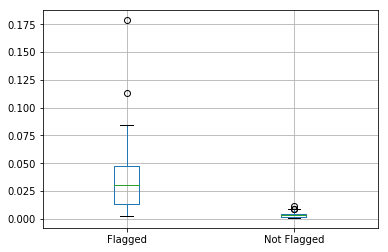

In [67]:
#Load model with best parameters
model.load_state_dict(t.load(proj_folder + 'simple_model.pt'))

#Create Data frame for box chart 
loss_lab = list(zip(*loss_lab_list))
dist_loss = np.array(list(loss_lab[0]))
dist_lab = np.array(list(loss_lab[1]))

distr = pd.DataFrame(columns = ['Flagged','Not Flagged'])
distr['Flagged'] = dist_loss[dist_lab == 1]
distr['Not Flagged'] = dist_loss[dist_lab != 1]

#Visualisation
print('MSE distribution in test samples:')
distr.boxplot()
distr.describe()

## 11.Decide boundary 
To implement classificator, boundary value must be selected. Now it's done manually then some rule can be established.

**Falsly flagged** are preferd over **falsly not flagged**.  

Boundry can be selected either to maximize correct classifications either to safely classifie more samples as flagged.

In [68]:
# Select bondary value as quantile of Flagged Values
q = .3  # Magic numeber out of hat <- to be replaced by rule
class_boundary = distr['Flagged'].quantile(q)
print('Boundry selected as quantile %.2f of Flagged MSE.' % q)

#Check how many flagged classified correctly 
c1 = distr['Flagged'][distr['Flagged'] >= class_boundary]
print('Flagged correctly cassified: %d/%d ' % (len(c1), len(distr['Flagged'])) )

#Check how many not flagged classified correctly 
c2 = distr['Not Flagged'][distr['Not Flagged'] < class_boundary]
print('Not Flagged correctly cassified: %d/%d ' % (len(c2), len(distr['Not Flagged'])) )

#Total classification results
print('Total correctly cassified: %d/%d ' % (len(c2)+len(c1), 2*len(distr['Not Flagged'])) )

Boundry selected as quantile 0.30 of Flagged MSE.
Flagged correctly cassified: 49/70 
Not Flagged correctly cassified: 70/70 
Total correctly cassified: 119/140 


## 12.Example of explain function
Example of explain function that could classify samples using model and explain which features influenced the choice. 

In [69]:
#Get random flagged sample  
r = np.random.choice(f_indices)
#X is from preprocessing step of creating dataset. It's tensor of normalized data.
exp_sample = X[r]
if gpu:
    exp_sample = exp_sample.cuda()
    
model.eval()
output = model.forward(exp_sample)
loss = criterion(output, exp_sample)

print('MSE value for sample: %.7f with boundary %.7f' % (loss, class_boundary))

if loss >= class_boundary: 
    print('This sample is classified as FLAGGED.')
else:
    print('This sample is classified as NOT FLAGGED.')

#Get features that differ the most
feat_order = pd.DataFrame(columns=['Col','Feat_diff'])
feat_order['Col'] = filtered.columns
feat_order['Feat_diff'] = abs(exp_sample.cpu().data.numpy() - output.cpu().data.numpy())
feat_order = feat_order.sort_values('Feat_diff',ascending = False)

print('Features that differ the most from expected values are:')
feat_order.head()

MSE value for sample: 0.0021189 with boundary 0.0192579
This sample is classified as NOT FLAGGED.
Features that differ the most from expected values are:


,Col,Feat_diff
31,slopedZAPos,0.205360
32,offsetdZCPos,0.178952
134,deltaPtchi2A,0.168511
212,phiPullHighPt,0.163224
177,dcaz_negA_2,0.144019


##Result file example

In [70]:
#Run model on all data
X_r = X
X_r = X_r.cuda()
output_r = model.forward(X_r)

print(X[0])
print(output_r[0])

loss_func = nn.MSELoss()
losses = []
for d,o in zip(X_r, output_r):
    losses.append(loss_func(d,o).item())

result = pd.DataFrame()
result['period'] = period 
result['run'] = run 
result['chunkID'] = chunkID
result['scores'] = losses

result.to_csv('SimpleAE_result.csv')
result.head()

tensor([-1.0000,  0.9842,  0.8049,  0.9265,  0.7847, -0.1414,  0.0416,  0.0452,
         0.0416,  0.9816,  0.7703, -0.0091, -0.0051,  0.0393, -0.0051,  1.0000,
         0.1735,  0.2586,  0.0435,  0.2755, -0.2337,  0.0850,  0.0372,  0.0323,
         0.0123,  0.0145,  0.0673,  0.0673,  0.1271,  0.1271,  0.0607,  0.3115,
        -0.2507,  0.1003,  0.0110,  0.0190,  0.0060,  0.0069,  0.0203,  0.0203,
         0.1041,  0.1041,  0.0252,  0.0837, -0.1989,  0.0448,  0.0141,  0.0161,
         0.0092,  0.0127,  0.1365,  0.1365,  0.1546,  0.1546,  0.0808,  0.3255,
        -0.6843, -0.5355,  0.0296,  0.0339,  0.0000,  0.0000,  0.0417,  0.0417,
         0.1655,  0.1655,  0.0451,  0.1360,  0.0571,  0.1581,  0.1894, -0.1717,
        -0.2992, -0.1628,  0.0322,  0.0277,  0.0000,  0.0000,  0.0178,  0.0178,
         0.1669,  0.1669, -0.0464,  0.6789, -0.3537, -0.3717,  0.0114,  0.0150,
         0.0000,  0.0000,  0.2052,  0.2052,  0.1708,  0.1708,  0.0726,  0.9228,
         0.7423,  0.0726,  0.9810,  0.43

,period,run,chunkID,scores
0,LHC18f,287000,1,0.004933
1,LHC18f,287000,2,0.001733
2,LHC18f,287000,3,0.002753
3,LHC18f,287000,4,0.006438
4,LHC18f,287000,5,0.002859


In [0]:
#Count sum loss and aeScore from data 
def getScores(scores, labels, scale):
    if scale: #If scale scale scores 0-1
        min_max_scaler = preprocessing.MinMaxScaler()
        scores = min_max_scaler.fit_transform(np.array(scores).reshape(-1,1)).squeeze()

    tot_loss = 0
    outliers = []
    corr = []
    for s,l in zip(scores,labels):
        tot_loss += s
        if l:
            outliers.append(s)
        else:
            corr.append(s)
        
    loss = tot_loss / len(labels)
    asScore = sum(outliers)/len(outliers)  -  sum(corr)/len(corr)
    return loss,asScore 

In [72]:
loss, asScore = getScores(losses,raw[war_col],True)

print('Total loss: {:.2f}'.format(loss*1000))
print('AutoEncoder Score: {:.2f}'.format(asScore*1000))

Total loss: 16.00
AutoEncoder Score: 121.18
